# Example Notebook

In [1]:
import numpy as np
import datajoint as dj
import sys
import matplotlib.pyplot as plt
from bisect import bisect_left

dj_local_conf_path = "/Users/pauladkisson/Documents/CatalystNeuro/JadhavConv/jadhav-lab-to-nwb/src/jadhav_lab_to_nwb/spyglass_mock/dj_local_conf.json"
dj.config.load(dj_local_conf_path)  # load config for database connection info

# General Spyglass Imports
import spyglass.common as sgc  # this import connects to the database
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

# Spike Sorting Imports
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput
import spyglass.spikesorting.v1 as sgs
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup
from spyglass.spikesorting.analysis.v1.group import UnitSelectionParams
from spyglass.spikesorting.analysis.v1.unit_annotation import UnitAnnotation

# LFP Imports
import spyglass.lfp as sglfp

# DLC Imports
from spyglass.position.v1.imported_pose import ImportedPose

# Custom Table Imports
sys.path.append(
    "/Users/pauladkisson/Documents/CatalystNeuro/JadhavConv/jadhav-lab-to-nwb/src/jadhav_lab_to_nwb/spyglass_extensions"
)
from task_leds import TaskLEDs

[2025-06-30 14:51:38,946][INFO]: DataJoint is configured from /Users/pauladkisson/Documents/CatalystNeuro/JadhavConv/jadhav-lab-to-nwb/src/jadhav_lab_to_nwb/spyglass_mock/dj_local_conf.json
[2025-06-30 14:51:39,520][INFO]: DataJoint 0.14.4 connected to root@localhost:3306
[14:51:44][INFO] Spyglass: Initializing UserEnvironment for spikesorting: root_spyglass_00


This notebook showcases the example session from the olson_2024 dataset containing navigation behavior and concurrent SpikeGadgets recordings in hippocampal subfield CA1 and subiculum.

All data is loaded from the spyglass database.
In order to run this notebook, please ensure that data has been inserted into the database using the `olson_2024_insert_session.py` script.

In [2]:
sgc.Session()

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
sub-SL18_ses-D19_.nwb,SL18,Brandeis University,Jadhav,None,"CA1 and subiculum (SUB) are two main output regions of the hippocampus, projecting to highly overlapping cortical and subcortical regions. The manner and extent of coordination between rodent CA1 and SUB during the learning of memory-guided navigation is largely unknown. We are therefore recording these two regions simultaneously while rats learn a memory-guided navigation task in a complex track environment.",2023-05-03 11:26:42,2023-05-03 11:26:42,None
sub-XFN1_ses-07-15-2023-100_.nwb,XFN1,Brandeis University,Jadhav,07-15-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-15 00:00:00,2023-07-15 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN1_ses-07-20-2023-100_.nwb,XFN1,Brandeis University,Jadhav,07-20-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-20 00:00:00,2023-07-20 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN1_ses-07-27-2023-100_.nwb,XFN1,Brandeis University,Jadhav,07-27-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-27 00:00:00,2023-07-27 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN1_ses-08-03-2023-50_.nwb,XFN1,Brandeis University,Jadhav,08-03-2023-50,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 50% of the time when both rats poked the same well.,2023-08-03 00:00:00,2023-08-03 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are

In [3]:
nwb_file_name = get_nwb_copy_filename("sub-SL18_ses-D19.nwb")
sgc.Session() & {"nwb_file_name": nwb_file_name}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
sub-SL18_ses-D19_.nwb,SL18,Brandeis University,Jadhav,None,"CA1 and subiculum (SUB) are two main output regions of the hippocampus, projecting to highly overlapping cortical and subcortical regions. The manner and extent of coordination between rodent CA1 and SUB during the learning of memory-guided navigation is largely unknown. We are therefore recording these two regions simultaneously while rats learn a memory-guided navigation task in a complex track environment.",2023-05-03 11:26:42,2023-05-03 11:26:42,None


Notice that task epochs alternate between Sleep and a behavioral shuttle task.

In [4]:
sgc.TaskEpoch() & {"nwb_file_name": nwb_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),task_name,camera_name,interval_list_name descriptive name of this interval list,task_environment the environment the animal was in,camera_names list of keys corresponding to entry in CameraDevice
sub-SL18_ses-D19_.nwb,1,Sleep,None,01,SLP,=BLOB=
sub-SL18_ses-D19_.nwb,2,HomeAltVisitAll,None,02,BOX,=BLOB=
sub-SL18_ses-D19_.nwb,3,Sleep,None,03,SLP,=BLOB=
sub-SL18_ses-D19_.nwb,4,HomeAltVisitAll,None,04,BOX,=BLOB=
sub-SL18_ses-D19_.nwb,5,Sleep,None,05,SLP,=BLOB=
sub-SL18_ses-D19_.nwb,6,HomeAltVisitAll,None,06,BOX,=BLOB=
sub-SL18_ses-D19_.nwb,7,Sleep,None,07,SLP,=BLOB=


Get plotting window (Middle of the first shuttle task epoch, i.e. epoch 2)

In [5]:
plotting_start_time = 3500.0
plotting_stop_time = plotting_start_time + 5.0  # 5 second window
print(f"Plotting window: {plotting_start_time} to {plotting_stop_time} seconds")
electrical_series = (sgc.Raw & {"nwb_file_name": nwb_file_name}).fetch_nwb()[0]["raw"]
plotting_start_index = bisect_left(electrical_series.timestamps, plotting_start_time)
plotting_stop_index = bisect_left(electrical_series.timestamps, plotting_stop_time)
plotting_slice = slice(plotting_start_index, plotting_stop_index)
print(f"Plotting indices: {plotting_start_index} to {plotting_stop_index} (exclusive)")

Plotting window: 3500.0 to 3505.0 seconds
Plotting indices: 86443818 to 86593818 (exclusive)


Get electrodes for nTrode1

In [6]:
sgc.Electrode()

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_id a unique ID for this probe & dynamic config,probe_shank unique shank number within probe.,"probe_electrode electrode ID, output from acquisition",region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
sub-SL18_ses-D19_.nwb,nTrode1,8,nTrode1_probe_type,0,65,1,8,65,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-SL18_ses-D19_.nwb,nTrode1,21,nTrode1_probe_type,0,67,1,21,67,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-SL18_ses-D19_.nwb,nTrode1,34,nTrode1_probe_type,0,69,1,34,69,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-SL18_ses-D19_.nwb,nTrode1,47,nTrode1_probe_type,0,71,1,47,71,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-SL18_ses-D19_.nwb,nTrode12,64,nTrode12_probe_type,0,137,2,64,137,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-SL18_ses-D19_.nwb,nTrode12,80,nTrode12_probe_type,0,139,2,80,139,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-SL18_ses-D19_.nwb,nTrode12,96,nTrode12_probe_type,0,141,2,96,141,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-SL18_ses-D19_.nwb,nTrode12,112,nTrode12_probe_type,0,143,2,112,143,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-SL18_ses-D19_.nwb,nTrode13,124,nTrode13_probe_type,0,145,2,124,145,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-SL18_ses-D19_.nwb,nTrode13,136,nTrode13_probe_type,0,147,2,136,147,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,


In [7]:
nTrode1_electrodes = sgc.Electrode() & {"electrode_group_name": "nTrode1"}
electrode_indices = nTrode1_electrodes.fetch("electrode_id")
nTrode1_electrodes

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_id a unique ID for this probe & dynamic config,probe_shank unique shank number within probe.,"probe_electrode electrode ID, output from acquisition",region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
sub-SL18_ses-D19_.nwb,nTrode1,8,nTrode1_probe_type,0,65,1,8,65,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-SL18_ses-D19_.nwb,nTrode1,21,nTrode1_probe_type,0,67,1,21,67,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-SL18_ses-D19_.nwb,nTrode1,34,nTrode1_probe_type,0,69,1,34,69,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,
sub-SL18_ses-D19_.nwb,nTrode1,47,nTrode1_probe_type,0,71,1,47,71,nan,nan,nan,unfiltered,nan,False,0.0,0.0,0.0,


Get LFP index for nTrode1 and plotting_slice

In [8]:
lfp_electrical_series = (sglfp.ImportedLFP & {"nwb_file_name": nwb_file_name}).fetch_nwb()[0]["lfp"]
lfp_indices = []
for electrode_index in electrode_indices:
    if electrode_index not in lfp_electrical_series.electrodes.data[:]:
        continue
    nTrode1_lfp_index = np.where(lfp_electrical_series.electrodes.data[:] == electrode_index)[0][0]
    lfp_indices.append(nTrode1_lfp_index)
assert len(lfp_indices) == 1, "We expect only one LFP index for nTrode1, but found multiple."
nTrode1_lfp_index = lfp_indices[0]
print(f"nTrode1 LFP index: {nTrode1_lfp_index}")

lfp_plotting_start_index = bisect_left(lfp_electrical_series.timestamps, plotting_start_time)
lfp_plotting_stop_index = bisect_left(lfp_electrical_series.timestamps, plotting_stop_time)
lfp_plotting_slice = slice(lfp_plotting_start_index, lfp_plotting_stop_index)

nTrode1 LFP index: 8


Get Units for nTrode1

In [9]:
nTrode1_unit_indices = (UnitAnnotation.Annotation() & {"annotation": "nTrode", "label": 1}).fetch("unit_id")
nTrode1_unit_inds = []
for i, unit_id in enumerate(nTrode1_unit_indices):
    annotations = UnitAnnotation.Annotation() & {"unit_id": unit_id}
    display(annotations)
    unit_ind = (annotations & {"annotation": "unitInd"}).fetch("label")
    nTrode1_unit_inds.append(unit_ind)

group_key = {
        "nwb_file_name": nwb_file_name,
        "sorted_spikes_group_name": "all_units",
    }
group_key = (SortedSpikesGroup & group_key).fetch1("KEY")
spike_data = SortedSpikesGroup().fetch_spike_data(group_key)
nTrode1_spike_data = [spike_data[i] for i in nTrode1_unit_indices]

spikesorting_merge_id,unit_id,"annotation the kind of annotation (e.g. a table name, ""cell_type"", ""firing_rate"", etc.)",label text labels from analysis,quantification quantification label from analysis
c24ae95e-0470-b26d-4bd9-96b9d905c854,59,globalID,nTrode1_unit1,nan
c24ae95e-0470-b26d-4bd9-96b9d905c854,59,nTrode,1,nan
c24ae95e-0470-b26d-4bd9-96b9d905c854,59,nWaveforms,None,3585.0
c24ae95e-0470-b26d-4bd9-96b9d905c854,59,unitInd,1,nan
c24ae95e-0470-b26d-4bd9-96b9d905c854,59,waveformFWHM,None,0.238071
c24ae95e-0470-b26d-4bd9-96b9d905c854,59,waveformPeakMinusTrough,None,1136.0


spikesorting_merge_id,unit_id,"annotation the kind of annotation (e.g. a table name, ""cell_type"", ""firing_rate"", etc.)",label text labels from analysis,quantification quantification label from analysis
c24ae95e-0470-b26d-4bd9-96b9d905c854,60,globalID,nTrode1_unit2,nan
c24ae95e-0470-b26d-4bd9-96b9d905c854,60,nTrode,1,nan
c24ae95e-0470-b26d-4bd9-96b9d905c854,60,nWaveforms,None,10745.0
c24ae95e-0470-b26d-4bd9-96b9d905c854,60,unitInd,2,nan
c24ae95e-0470-b26d-4bd9-96b9d905c854,60,waveformFWHM,None,0.296261
c24ae95e-0470-b26d-4bd9-96b9d905c854,60,waveformPeakMinusTrough,None,1103.0


spikesorting_merge_id,unit_id,"annotation the kind of annotation (e.g. a table name, ""cell_type"", ""firing_rate"", etc.)",label text labels from analysis,quantification quantification label from analysis
c24ae95e-0470-b26d-4bd9-96b9d905c854,61,globalID,nTrode1_unit3,nan
c24ae95e-0470-b26d-4bd9-96b9d905c854,61,nTrode,1,nan
c24ae95e-0470-b26d-4bd9-96b9d905c854,61,nWaveforms,None,10975.0
c24ae95e-0470-b26d-4bd9-96b9d905c854,61,unitInd,3,nan
c24ae95e-0470-b26d-4bd9-96b9d905c854,61,waveformFWHM,None,0.287069
c24ae95e-0470-b26d-4bd9-96b9d905c854,61,waveformPeakMinusTrough,None,745.0


spikesorting_merge_id,unit_id,"annotation the kind of annotation (e.g. a table name, ""cell_type"", ""firing_rate"", etc.)",label text labels from analysis,quantification quantification label from analysis
c24ae95e-0470-b26d-4bd9-96b9d905c854,62,globalID,nTrode1_unit4,nan
c24ae95e-0470-b26d-4bd9-96b9d905c854,62,nTrode,1,nan
c24ae95e-0470-b26d-4bd9-96b9d905c854,62,nWaveforms,None,295.0
c24ae95e-0470-b26d-4bd9-96b9d905c854,62,unitInd,4,nan
c24ae95e-0470-b26d-4bd9-96b9d905c854,62,waveformFWHM,None,0.25428
c24ae95e-0470-b26d-4bd9-96b9d905c854,62,waveformPeakMinusTrough,None,1482.0


Retrieve Ephys Data for nTrode1

In [10]:
# Ephys
electrical_series_data = electrical_series.data[plotting_slice, electrode_indices]
raw_to_uV = electrical_series.conversion * 1e6
electrical_series_in_uV = electrical_series_data * raw_to_uV
electrical_series_timestamps = np.asarray(electrical_series.timestamps[plotting_slice])
lfp_data = np.asarray(lfp_electrical_series.data[lfp_plotting_slice, nTrode1_lfp_index])
lfp_conversion = lfp_electrical_series.conversion * 1e6
lfp_in_uV = lfp_data * lfp_conversion
lfp_timestamps = np.asarray(lfp_electrical_series.timestamps[lfp_plotting_slice])

# Sorted Units
spike_times = []
for spikes in nTrode1_spike_data:
    plotting_spike_time_mask = (spikes >= plotting_start_time) & (spikes < plotting_stop_time)
    plotting_spike_times = spikes[plotting_spike_time_mask]
    spike_times.append(plotting_spike_times)

Plot Example Tetrode

Text(0.5, 0, 'Time (s)')

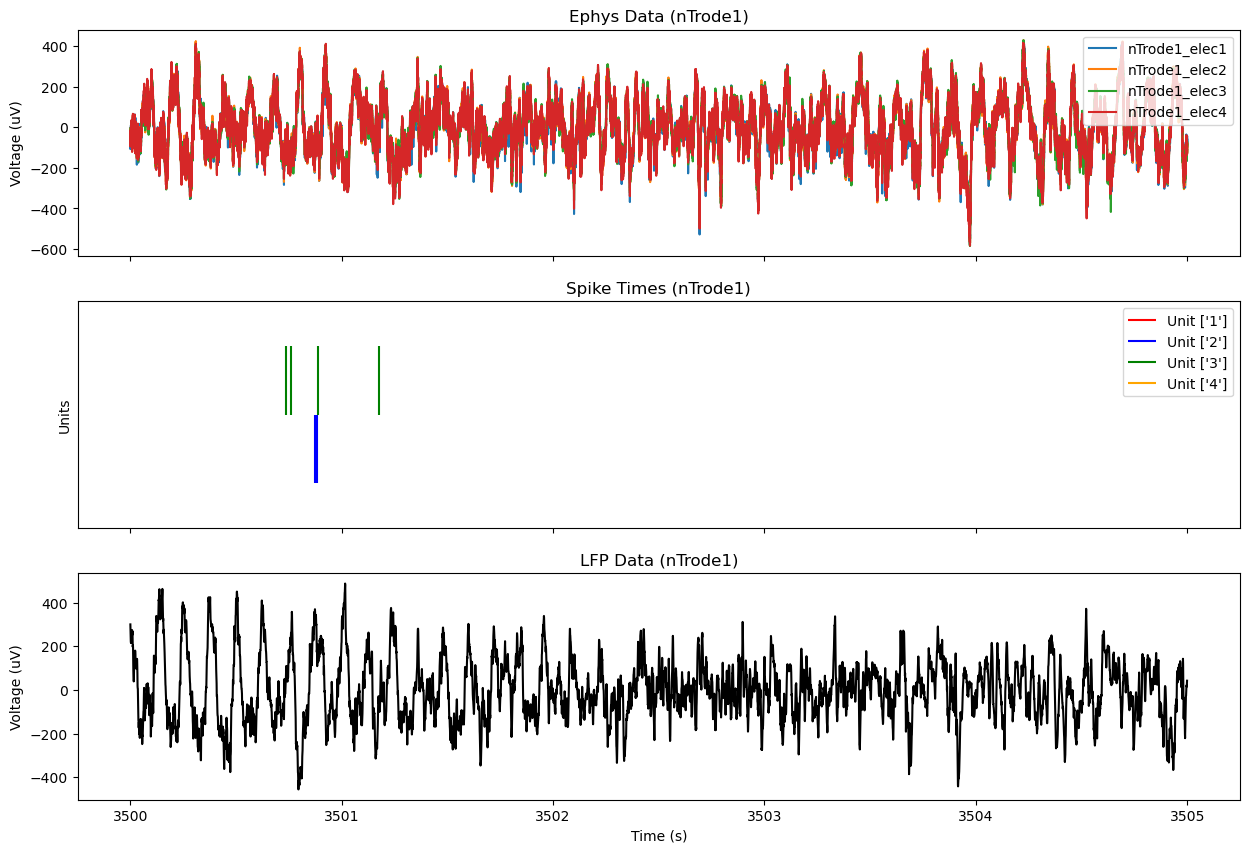

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
ax[0].plot(electrical_series_timestamps, electrical_series_in_uV)
ax[0].set_ylabel("Voltage (uV)")
ax[0].set_title("Ephys Data (nTrode1)")
ax[0].legend([f"nTrode1_elec{i}" for i in range(1, 5)], loc='upper right')
colors = ['red', 'blue', 'green', 'orange']
for i, unit_ind in enumerate(nTrode1_unit_inds):
    ax[1].eventplot(spike_times[i], lineoffsets=i, colors=colors[i], label=f"Unit {unit_ind}")
ax[1].set_yticks([])
ax[1].set_ylabel("Units")
ax[1].set_title("Spike Times (nTrode1)")
ax[1].legend()

ax[2].plot(lfp_timestamps, lfp_in_uV, color='black')
ax[2].set_ylabel("Voltage (uV)")
ax[2].set_title("LFP Data (nTrode1)")
ax[2].set_xlabel("Time (s)")

Get Behavior Data for second epoch

In [12]:
sgc.DIOEvents()

nwb_file_name name of the NWB file,dio_event_name the name assigned to this DIO event,dio_object_id the object id of the data in the NWB file,interval_list_name descriptive name of this interval list
sub-SL18_ses-D19_.nwb,reward_pump_1,d0aa8519-a440-4c4f-830f-5367293916c1,raw data valid times
sub-SL18_ses-D19_.nwb,reward_pump_2,571dcba6-2480-4cad-b2c4-c9b1097e2fa1,raw data valid times
sub-SL18_ses-D19_.nwb,reward_pump_3,e99d6316-87c8-4dfa-bb37-9b88423eb4bc,raw data valid times
sub-SL18_ses-D19_.nwb,reward_pump_4,6c43c54f-cd3a-4440-9f14-fa5d80804b4d,raw data valid times
sub-SL18_ses-D19_.nwb,reward_pump_5,92f98053-7849-4b1b-8c04-03c9bd7faf8f,raw data valid times
sub-SL18_ses-D19_.nwb,reward_well_1,abe4193a-cde4-4f9d-9293-d6835f977285,raw data valid times
sub-SL18_ses-D19_.nwb,reward_well_2,321a86ab-de15-48bc-b2a3-c1e25930613e,raw data valid times
sub-SL18_ses-D19_.nwb,reward_well_3,53e6282a-6e0e-49d7-bb5e-342cc685bda1,raw data valid times
sub-SL18_ses-D19_.nwb,reward_well_4,b4cead2b-5c9f-4196-a389-87db277e7a2d,raw data valid times
sub-SL18_ses-D19_.nwb,reward_well_5,fbec1495-a884-4363-9da4-a2216e39bc71,raw data valid times


In [13]:
event_names = [
    "reward_well_1",
    "reward_well_2",
    "reward_well_3",
    "reward_well_4",
    "reward_well_5",
    "reward_well_6",
    "reward_well_7",
    "reward_well_8",
    "reward_pump_1",
    "reward_pump_2",
    "reward_pump_3",
    "reward_pump_4",
    "reward_pump_5",
]
name_to_timestamps = {}
for name in event_names:
    time_series = (sgc.DIOEvents & {"nwb_file_name": nwb_file_name, "dio_event_name": name}).fetch_nwb()[0]["dio"]
    name_to_timestamps[name] = time_series.timestamps[:]
start_time, stop_time = (sgc.IntervalList & {"nwb_file_name": nwb_file_name, "interval_list_name": "02"}).fetch1("valid_times")[0]
name_to_timestamps_plotting = {
    name: timestamps[(timestamps >= start_time) & (timestamps < stop_time)]
    for name, timestamps in name_to_timestamps.items()
}

Plot Behavior Data

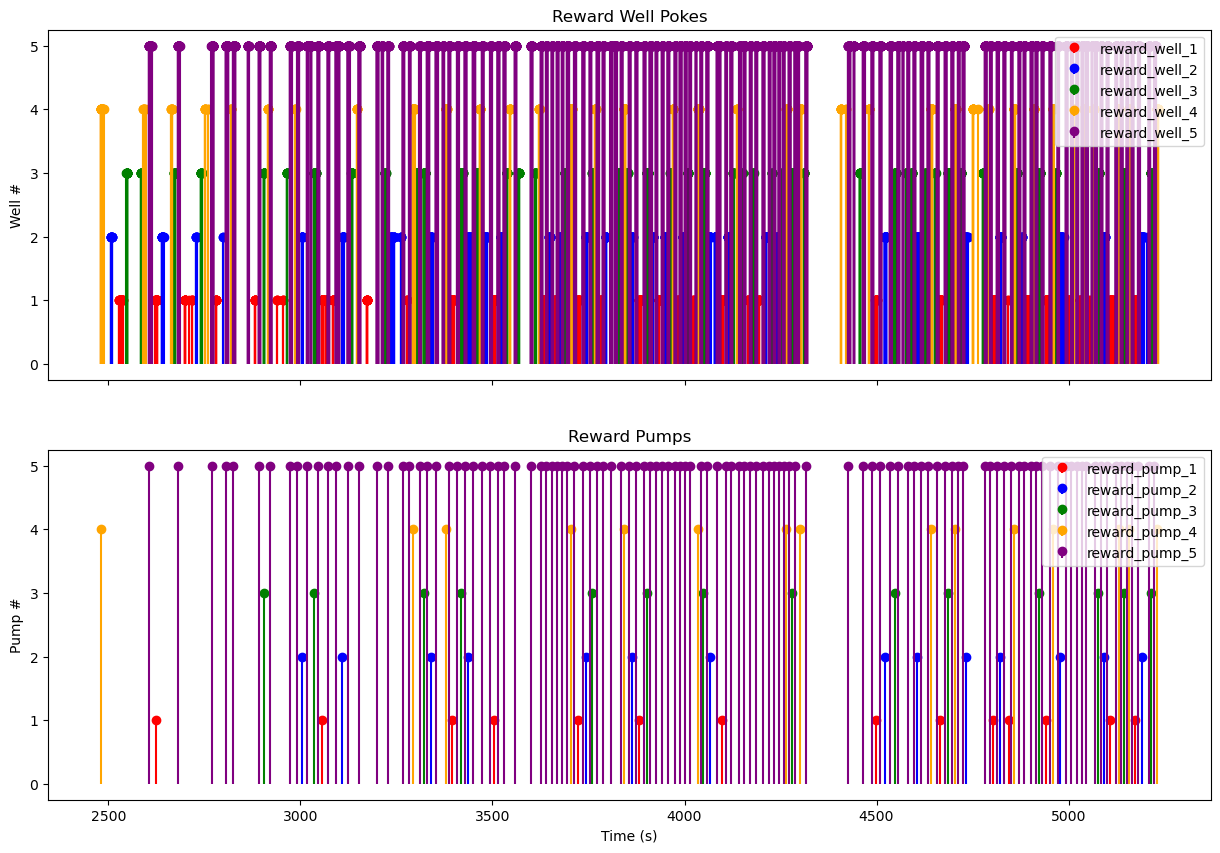

In [14]:
well_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot reward well pokes
for i in range(1, 9):
    well_name = f"reward_well_{i}"
    if name_to_timestamps_plotting[well_name].size == 0:
        continue
    axs[0].stem(name_to_timestamps_plotting[well_name], 
                np.ones_like(name_to_timestamps_plotting[well_name]) * i, 
                linefmt=f'{well_colors[i-1]}', 
                markerfmt=f'{well_colors[i-1]}', 
                basefmt=' ', 
                label=well_name)

# Plot reward pumps
for i in range(1, 6):
    pump_name = f"reward_pump_{i}"
    if name_to_timestamps_plotting[pump_name].size == 0:
        continue
    axs[1].stem(name_to_timestamps_plotting[pump_name], 
                np.ones_like(name_to_timestamps_plotting[pump_name]) * i, 
                linefmt=f'{well_colors[i-1]}', 
                markerfmt=f'{well_colors[i-1]}', 
                basefmt=' ', 
                label=pump_name)
    
# Add axis labels and titles
axs[0].set_ylabel("Well #")
axs[0].set_title("Reward Well Pokes")

axs[1].set_ylabel("Pump #")
axs[1].set_title("Reward Pumps")
axs[1].set_xlabel("Time (s)")

# Show legends
for ax in axs:
    ax.legend(loc="upper right")

Get DLC data for the second epoch

In [15]:
ImportedPose()

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,pose_object_id unique identifier for the pose object,skeleton_object_id unique identifier for the skeleton object
sub-SL18_ses-D19_.nwb,pose_PoseEstimation_S01_F01_BOX_SLP_valid_intervals,060152e6-4f84-4acf-9d72-8981a1e987fc,255ca6e6-8afc-4128-ad17-6e699d6ffa94
sub-SL18_ses-D19_.nwb,pose_PoseEstimation_S02_F01_Home+4_HomeAltVisitAll_valid_intervals,9f421e86-dcae-43ac-9b6f-125713d81d98,409547d9-84ba-409a-85a3-72b1410ae095
sub-SL18_ses-D19_.nwb,pose_PoseEstimation_S03_F01_BOX_SLP_valid_intervals,c05442af-57d7-4dbb-bcb8-4282f33e85c5,9b54431e-a465-4ff3-9d6a-473ac4114201
sub-SL18_ses-D19_.nwb,pose_PoseEstimation_S04_F01_Home+4_HomeAltVisitAll_valid_intervals,49bb0f47-702a-4af0-982f-86778ebb9d3a,ce93ace1-521b-4269-aa64-042c6348dc84
sub-SL18_ses-D19_.nwb,pose_PoseEstimation_S05_F01_BOX_SLP_valid_intervals,c31bb310-98a6-4817-90c2-0db361022959,73b590de-1944-4173-9916-a6eae65cd3c4
sub-SL18_ses-D19_.nwb,pose_PoseEstimation_S06_F01_Home+4_HomeAltVisitAll_valid_intervals,1e737818-7784-4618-8f73-ec3a9539d0d7,e0b4455c-e2a8-4fa0-ba6e-0ee4c74c8e7b
sub-SL18_ses-D19_.nwb,pose_PoseEstimation_S07_F01_BOX_SLP_valid_intervals,7e14b798-ea13-4c29-a348-3ffe82561823,58f8ae21-590b-4697-bc14-17b28633ca84
sub-XFN1_ses-07-15-2023-100_.nwb,pose_PoseEstimation_1-XFN1-1_valid_intervals,638bc177-c0db-4fea-b875-114cfd823d76,2d128509-e527-467d-b6f7-5f1fc894444b
sub-XFN1_ses-07-15-2023-100_.nwb,pose_PoseEstimation_1-XFN3-1_valid_intervals,5356156a-7232-4b85-b639-390d8383387a,9c89d0f6-22d4-495d-934e-bd0f5ff2c830
sub-XFN1_ses-07-20-2023-100_.nwb,pose_PoseEstimation_1-XFN1-1_valid_intervals,f4122f80-085e-4789-8526-d74fa0628e15,b5d1bfc2-c5d4-4894-aaf9-96744b906361


In [16]:
pose_estimation = (ImportedPose & {"nwb_file_name": nwb_file_name, "interval_list_name": "pose_PoseEstimation_S02_F01_Home+4_HomeAltVisitAll_valid_intervals"}).fetch_nwb()[0]["pose"]
pose_estimation_series = pose_estimation.pose_estimation_series
name_to_data = {name: series.data[:] for name, series in pose_estimation_series.items()}
pes_timestamps = pose_estimation_series["PoseEstimationSeriesBaseoftail"].timestamps[:]

Plot DLC data

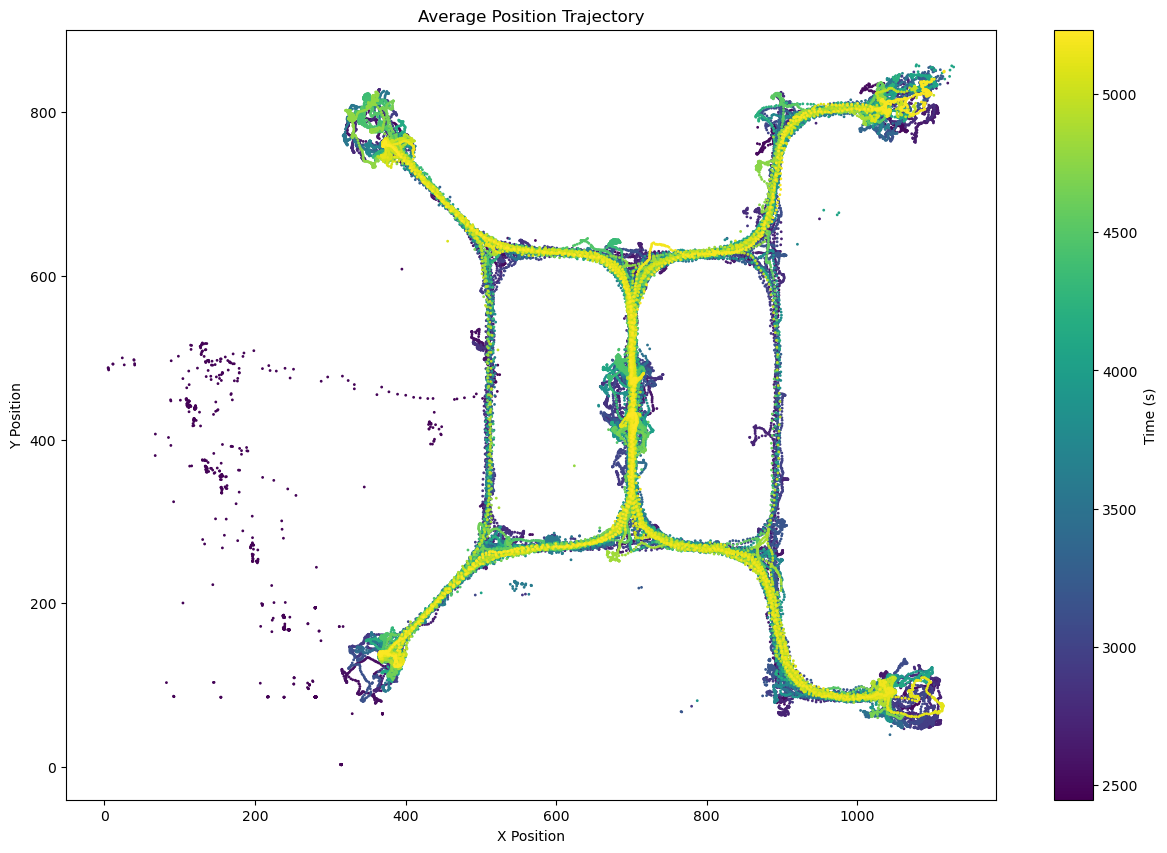

In [17]:
plt.figure(figsize=(15, 10))
all_x = np.array([data[:, 0] for data in name_to_data.values()])
all_y = np.array([data[:, 1] for data in name_to_data.values()])

x = np.nanmean(all_x, axis=0)
y = np.nanmean(all_y, axis=0)

sc = plt.scatter(x, y, c=pes_timestamps, cmap='viridis', s=1)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Average Position Trajectory')
plt.colorbar(sc, label='Time (s)')